In [43]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os
import cv2
import matplotlib.pyplot as plt

In [47]:
!pip install opencv-python --user

In [19]:
def EncoderLayer():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),]

In [20]:
def DecoderLayer():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(512, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(256, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),

            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(128, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),]

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Layer(input_shape=(256, 256,3)))
model.encoding_layers = EncoderLayer()
model.decoding_layers = DecoderLayer()
for layer in model.encoding_layers:
    model.add(layer)
for layer in model.decoding_layers:
    model.add(layer)
model.add(keras.layers.Conv2D(13,1,1, padding = 'same'))
model.add(keras.layers.Activation(activation = 'softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0

In [3]:
def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        
        k = k+1

    return X, y

In [4]:
# Directories containing the train and val data
train_files = "./data/cityscapes_data/train/"
val_files = "./data/cityscapes_data/val/"

# Setup image-label pairs
x_train, y_train = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)
x_val, y_val = dataset_setup(data_dir=val_files, n_ims=500, offset_bias=0, img_dim=256)

In [9]:
x_train1 = x_train[:20]
y_train1 = y_train[:20]

In [10]:
from sklearn.cluster import KMeans
colors = []
for i in range(len(x_train1)//2):
    colors.append(y_train1[i].reshape(y_train1[i].shape[0]*y_train1[i].shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

In [12]:
x_train1 = x_train[:500]
y_train1 = y_train[:500]

In [14]:
labels = []
for i in range(500):
    labels.append(ColorsToClass(y_train[i]))
labels = np.array(labels)

In [30]:
nb_epoch = 100
batch_size = 10
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [31]:
history = model.fit(x_train1, labels, batch_size=batch_size, epochs=nb_epoch,verbose=1)

Train on 500 samples
Epoch 1/100
500/500 [==============================] - 27s 53ms/sample - loss: 0.8456 - accuracy: 0.6335
Epoch 2/100
500/500 [==============================] - 18s 36ms/sample - loss: 0.7494 - accuracy: 0.6560
Epoch 3/100
500/500 [==============================] - 19s 39ms/sample - loss: 0.7154 - accuracy: 0.6655
Epoch 4/100
500/500 [==============================] - 18s 35ms/sample - loss: 0.6960 - accuracy: 0.6702
Epoch 5/100
500/500 [==============================] - 18s 35ms/sample - loss: 0.6913 - accuracy: 0.6720
Epoch 6/100
500/500 [==============================] - 18s 35ms/sample - loss: 0.6592 - accuracy: 0.6792
Epoch 7/100
500/500 [==============================] - 18s 36ms/sample - loss: 0.6460 - accuracy: 0.6841
Epoch 8/100
500/500 [==============================] - 17s 35ms/sample - loss: 0.6385 - accuracy: 0.6854
Epoch 9/100
500/500 [==============================] - 18s 35ms/sample - loss: 0.6220 - accuracy: 0.6907
Epoch 10/100
500/500 [============

In [25]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

In [50]:
history.history

{'loss': [0.8455789959430695,
  0.7494367814064026,
  0.7154189491271973,
  0.6959802627563476,
  0.6912905263900757,
  0.6591834878921509,
  0.6459552997350693,
  0.6384718304872513,
  0.6220145291090011,
  0.614802942276001,
  0.600194638967514,
  0.5920190280675888,
  0.5817890965938568,
  0.5668632674217224,
  0.5583618539571762,
  0.5461786460876464,
  0.5352806156873703,
  0.5297149246931077,
  0.5148182874917984,
  0.5108111292123795,
  0.5013946658372879,
  0.4931113398075104,
  0.4796976351737976,
  0.47208760857582094,
  0.45991818368434906,
  0.45903289675712583,
  0.45080854415893556,
  0.436728698015213,
  0.42799600183963776,
  0.4216392195224762,
  0.40179178774356844,
  0.403398756980896,
  0.3779922926425934,
  0.37945145785808565,
  0.384744815826416,
  0.3499788510799408,
  0.33663769602775573,
  0.3218041080236435,
  0.30749311566352844,
  0.29299089521169663,
  0.2871911597251892,
  0.2725080680847168,
  0.26764960259199144,
  0.2652537101507187,
  0.25826144427061

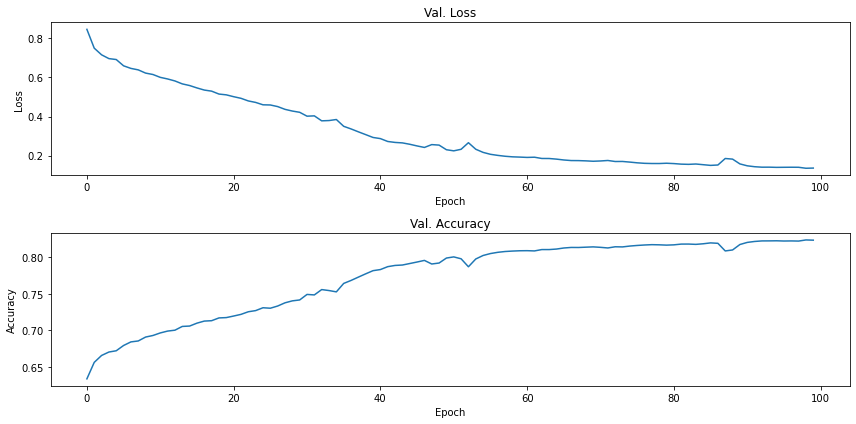

In [53]:
loss = history.history["loss"]
acc = history.history["accuracy"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


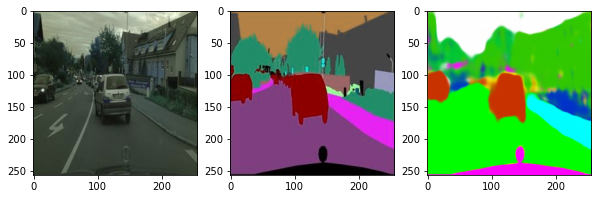

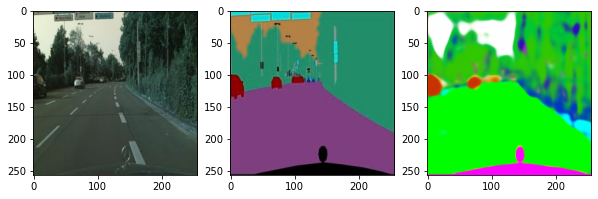

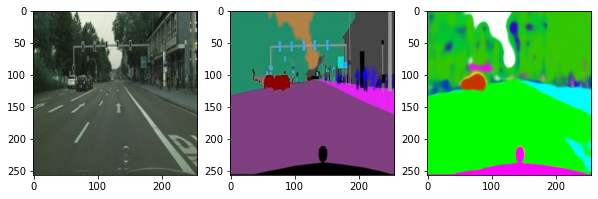

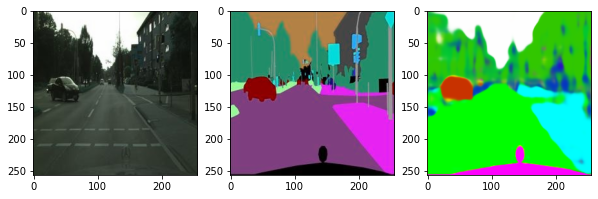

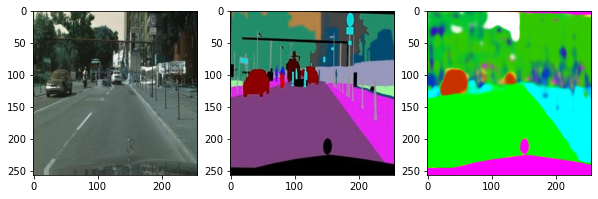

In [32]:
pp = model.predict(x_val[0:5,:,:,:])
ni = 5
for k in range(ni):
    pred = LayersToRGBImage(pp[k])
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pred)

In [44]:
scores = []
pp = model.predict(x_val)
for i in range(len(pp)):
    a = LayersToRGBImage(pp[i])
    b = y_val[i]
    intersection = np.logical_and(b, a)
    union = np.logical_or(b, a)
    iou_score = np.sum(intersection) / np.sum(union)
    scores.append(iou_score)

In [46]:
len(scores)

500

In [47]:
sum(scores)/len(scores)

0.9192433776855461